http://lance-modis.eosdis.nasa.gov/imagery/subsets/?mosaic=Arctic.2015152.terra.4km

In [1]:
%matplotlib inline

In [2]:
from numpy import asarray, zeros, reshape, double, arange, \
                  ma, log10, diff, mean, flipud, floor, pi, sqrt, size, fliplr, meshgrid, exp, cos, radians

In [3]:
from IPython.html import widgets
# [widget for widget in dir(widgets) if widget.endswith('Widget')]

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [4]:
import datetime

import matplotlib.pyplot as plt

from matplotlib.mlab import find

from PIL import Image

from scipy.signal import wiener

import os

__author__   = 'Alexander Myasoedov'
__email__    = 'mag@rshu.ru'
__created__  = datetime.datetime(2014, 10, 28)
__modified__ = datetime.datetime(2015, 6, 19)
__version__  = "1.0"
__status__   = "Development"

# Files to process

In [5]:
# Liza Polar Low 2015 June 01
inpath = '/media/SOLabNFS2/tmp/different_SAR/sentinel-1/Liza_PL_01_June_2015/'
fileNameList = ['S1A_EW_GRDM_1SDH_20150601T173700_20150601T173804_006183_0080D9_94AD.zip',
                'S1A_EW_GRDM_1SDH_20150601T173804_20150601T173858_006183_0080D9_E1A6.zip',
                'S1A_IW_GRDH_1SDV_20150601T173611_20150601T173644_006183_0080D8_B3F1.zip']

# Ania_Ladoga_29_May_2015/
inpath = '/media/SOLabNFS2/tmp/different_SAR/sentinel-1/Ania_Ladoga_29_May_2015/'
fileNameList = ['S1A_IW_GRDH_1SDV_20150603T154002_20150603T154027_006211_0081A9_5F10.zip',
                'S1A_IW_GRDH_1SDV_20150529T041657_20150529T041722_006131_007F51_F751.zip',
                'S1A_EW_GRDM_1SDH_20150517T153117_20150517T153221_005963_007AED_56B0.zip']

fn = fileNameList[0]

# Gulf of Finland 22 June 2015
inpath = '/media/SOLabNFS2/tmp/different_SAR/sentinel-1/'
fn = 'S1A_IW_GRDH_1SDV_20150622T041659_20150622T041724_006481_008978_48EC.zip'
# crop = '[600:1400,0:900]'

# # Sevastopol 19 June 2015
# inpath = '/media/SOLabNFS2/tmp/different_SAR/sentinel-1/'
# fn = 'S1A_IW_GRDH_1SDV_20150619T035626_20150619T035653_006437_008838_32F1.zip'
# crop = '[1000:2500,1500:-1]'

# # Brazil/Amazon - no IWs
# inpath = '/media/SOLabNFS2/tmp/different_SAR/sentinel-1/'
# fn = 'S1A_IW_GRDH_1SDV_20150519T213443_20150519T213512_005996_007BA4_89FC.zip'

# Prirazlomnoe


In [6]:
from readS1 import *
import readS1
reload(readS1)

<module 'readS1' from 'readS1.pyc'>

In [7]:
# %%timeit -r 1 -n 1
scale = 1
pxlResSARm = 120

s1 = readS1.readS1(inpath=inpath, fn=fn, resolution=pxlResSARm)
# s1.__dict__['raw_counts']


Available polarizations: '[u'vv', u'vh']'
Reading raw_counts: 'vv' polarization
Reading raw_counts: 'vh' polarization
Interpolating LUTs: 'vv' polarization
Interpolating LUTs: 'vh' polarization


/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2221: DecompressionBombWarning: Image size (422605512 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [8]:
# get vars from s1 class
for k, v in s1.__dict__.iteritems():
    locals()[k]=v

In [9]:
sigma0w = {}
roughness = {}

for p in polarization:
    print "Filtering Image: \'%s\' polarization" %p
    
    # filter the image
    sigma0w[p] = wiener(sigma0[p][::scale,::scale], mysize=(7,7), noise=None)
#     sigma0w[p] = sigma0[p]

Filtering Image: 'vv' polarization
Filtering Image: 'vh' polarization


In [10]:
# import pyresample as pr
import sys
sys.path.append('/home/mag/Documents/repos/solab/pyresample2/')
# sys.path.append('/home/mag/Documents/repos/solab/pyresample2/pyresample2/')
import pyresample2 as pr

from pyproj import Proj

# S1 Pixel resolution
# we use pxlResSAR for further GSHHS rasterizing and reprojecting data with pyresample
lonlim = (lons_2[::scale,::scale].min(),lons_2[::scale,::scale].max())
latlim = (lats_2[::scale,::scale].min(),lats_2[::scale,::scale].max())

# enlarge lonlims for cropping a bit larger area for masking
lonlimGSHHS = (lonlim[0]-1.0, lonlim[1]+1.0)
latlimGSHHS = (latlim[0]-1.0, latlim[1]+1.0)


# Get first guess pixel resolution
import distancelib
pxlResSARm  = asarray(distancelib.getPixelResolution(lats_2[::scale,::scale], \
                                                     lons_2[::scale,::scale], \
                                                     lons_2[::scale,::scale].shape, 'km'))*1e3
pxlResSARdeg  = asarray(distancelib.getPixelResolution(lats_2[::scale,::scale], \
                                                       lons_2[::scale,::scale], \
                                                       lons_2[::scale,::scale].shape, 'deg'))

print "S1 cell resolution, %s deg"  % str(pxlResSARdeg)
print "S1 cell resolution, %s m"  % str(pxlResSARm)
# Define areas with pyresample
swath_def = pr.geometry.SwathDefinition(lons=lons_2[::scale,::scale], lats=lats_2[::scale,::scale])

# area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
#                           lonlim=lonlimGSHHS, latlim=latlimGSHHS, ellps="WGS84", res=(pxlResSARm,pxlResSARm))
area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
                          lonlim=lonlimGSHHS, latlim=latlimGSHHS, ellps="WGS84", res=pxlResSARm)

S1 cell resolution, [ 0.00109347  0.00107397] deg
S1 cell resolution, [ 121.50588439  119.33932003] m
up, down, left, right:  62.0 58.0 28.0 35.0


In [11]:
# Get the SAR pixel resolution from the area_def for further identical shapes
up    = min(latlimGSHHS)
down  = max(latlimGSHHS)
left  = min(lonlimGSHHS)
right = max(lonlimGSHHS)
area_extent_deg = (left, down, right, up)

area_extent_deg_shape = area_def_4326.shape

pxlResSARdeg = asarray( (abs(area_extent_deg[2] - area_extent_deg[0]) / float(area_extent_deg_shape[1]), \
                abs(area_extent_deg[3] - area_extent_deg[1]) / float(area_extent_deg_shape[0])) )

pxlResSARm = asarray( (area_def_4326.pixel_size_x, area_def_4326.pixel_size_y) )
print "S1 cell resolution, %s deg"  % str(pxlResSARdeg)
print "S1 cell resolution, %s m"  % str(pxlResSARm)


S1 cell resolution, [ 0.00109162  0.00107206] deg
S1 cell resolution, [ 121.51904692  119.34135045] m


In [12]:
# Apply Mask from GSHHS

import gshhs_rasterize
reload(gshhs_rasterize)

# ESRI shapefile containing land polygons
shapefile = '/media/SOLabNFS/store/auxdata/coastline/GSHHS_shp/f/GSHHS_f_L1.shp'

# reproject GSHHS onto S1 grid before calculations
print "Rasterizing Land Mask..."
mask_arr_4326 = gshhs_rasterize.gshhs_rasterize_4326(lonlimGSHHS, latlimGSHHS, \
                                     pxlResSARdeg, area_def_4326.shape, True, \
                                     shapefile)

Rasterizing Land Mask...


In [13]:
mask_arr_swath, scaling, intercept = pr.kd_tree.resample_nearest(area_def_4326, mask_arr_4326, swath_def, \
                                             radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, fill_value=None)

In [14]:
print area_def_4326.shape, mask_arr_4326.shape
print mask_arr_swath.shape, sigma0w[p].shape, swath_def.shape

(3643, 6445) (3643, 6445)
(1389, 2114) (1389, 2114) (1389, 2114)


In [15]:
from scipy.signal import medfilt

In [16]:
# Nice Image (Roughness)

sigma0wAvg = {}
roughnessNrmlzd = {}

if len(polarization[0])>=2: # if 2 polarizations
    for p in polarization:
        print "Nice Image: \'%s\' polarization" %p
        roughness[p] = ma.masked_where(mask_arr_swath.mask, sigma0w[p])
        sigma0wAvg[p] = ma.min(roughness[p], axis=0)
        roughnessNrmlzd[p] = (roughness[p]-sigma0wAvg[p])
#         roughnessNrmlzd[p] = (roughnessNrmlzd[p] - ma.median(roughnessNrmlzd[p], axis=0))/(ma.median(roughnessNrmlzd[p], axis=0))
        roughnessNrmlzd[p] = (roughnessNrmlzd[p])/medfilt(ma.mean(roughnessNrmlzd[p], axis=0),333)
elif len(polarization[0])==1: # if only 1 polarization
    p = polarization
    print "Nice Image: \'%s\' polarization" %p
    roughness[p] = ma.masked_where(mask_arr_swath.mask, sigma0w[p])
    sigma0wAvg[p] = ma.min(roughness[p], axis=0)
    roughnessNrmlzd[p] = (roughness[p]-sigma0wAvg[p])/sigma0wAvg[p]
# plt.imshow(roughnessNrmlzd['vv'], vmin=-1, vmax=3)
# plt.imshow(roughnessNrmlzd['vh'], vmin=-1, vmax=3)

Nice Image: 'vv' polarization
Nice Image: 'vh' polarization


# Adding Model wind

In [17]:
# Adding Model wind

# import xmltodict

# zf = zipfile.ZipFile(inpath+fn, 'r')
# manifest = zf.read(fn[:-4] + '.SAFE/manifest.safe')
# manifest = xmltodict.parse(manifest) # Parse the read document string
# zf.close()

startTime = datetime.datetime.strptime(\
                              manifest['xfdu:XFDU']['metadataSection']['metadataObject'][12]\
                              ['metadataWrap']['xmlData']['safe:acquisitionPeriod']['safe:startTime'],\
                              "%Y-%m-%dT%H:%M:%S.%f")

ncepGFSmodelWind = ncepGFSmodel(startTime, lats_2, lons_2)

In [18]:
# Reprojecting data

# import distancelib

# Pixel resolution
# we use pxlResWind/pxlResSAR for further pyresample radius_of_influence and sigmas
pxlResWind = asarray(distancelib.getPixelResolution(ncepGFSmodelWind['lats_wind'], \
                                                    ncepGFSmodelWind['lons_wind'], \
                                                    ncepGFSmodelWind['lons_wind'].shape, 'km'))
# pxlResSAR  = asarray(distancelib.getPixelResolution(lats_2, lons_2, lons_2.shape, 'km'))*1e3

# Note pxlResWind is in KM, multiply by 1e3 for meters
print "S1 cell resolution, %s m"  % pxlResSARm
print "Wind cell resolution, %s km" % pxlResWind

S1 cell resolution, [ 121.51904692  119.34135045] m
Wind cell resolution, [ 25.23639877  12.81286678] km


In [19]:
from scipy.interpolate import RectSphereBivariateSpline

def ncepGFSmodel2swath(lats, lons, data, lats_2, lons_2):

    func = RectSphereBivariateSpline(lats, lons, data)
    data_2 = func.ev(lats_2.ravel()*pi/180, \
                     lons_2.ravel()*pi/180)\
                     .reshape(lats_2.shape)
    return data_2


In [20]:
# reproject NCEP onto S1 grid before calculations
# Using RectSphereBivariateSpline - Bivariate spline approximation over a rectangular mesh on a sphere
# as it is much more efficiant for full resolution
# as well as smoothes nicely the image

# We don't want to work with full res wind so scaling the image for about 100m resolution
# Adjust scale to get appropriate value
# scale = 10

lts = flipud(ncepGFSmodelWind['lats_wind'])[:,0]*pi/180
lns = ncepGFSmodelWind['lons_wind'][0,:]*pi/180

lts_2 = lats_2[::scale,::scale]
lns_2 = lons_2[::scale,::scale]

ncepGFSmodelWindSwath = {}
ncepGFSmodelWindSwath['wind_speed'] = ncepGFSmodel2swath(lts, lns, flipud(ncepGFSmodelWind['wind_speed']), lts_2, lns_2)
ncepGFSmodelWindSwath['wind_dir']   = ncepGFSmodel2swath(lts, lns, flipud(ncepGFSmodelWind['wind_dir']),   lts_2, lns_2)
ncepGFSmodelWindSwath['u']   = ncepGFSmodel2swath(lts, lns, flipud(ncepGFSmodelWind['u']),   lts_2, lns_2)
ncepGFSmodelWindSwath['v']   = ncepGFSmodel2swath(lts, lns, flipud(ncepGFSmodelWind['v']),   lts_2, lns_2)
    
pxlResWindSwath = asarray(distancelib.getPixelResolution(lts_2, \
                                                    lns_2, \
                                                    lns_2.shape, 'km'))

print "Interpolated Wind cell resolution, %s m" % str(pxlResWindSwath*1e3)


Interpolated Wind cell resolution, [ 121.50588439  119.33932003] m


In [21]:
# calculate bearing from initial lats/lons for further wind calculation
# Taking initial values as bearing is more accurate after interpolation than vice versa
bearing = zeros((GEOgrid['lons'].shape[0]-1,GEOgrid['lons'].shape[1]))

for n in range(0,GEOgrid['lons'].shape[1]):
    col = ([GEOgrid['lats'][:-1,n], GEOgrid['lons'][:-1,n]], [GEOgrid['lats'][1:,n], GEOgrid['lons'][1:,n]])
    for m in range(0,GEOgrid['lons'].shape[0]-1):
        bearing[m][n] = distancelib.bearing(asarray(col[0])[:,m], asarray(col[1])[:,m])

# interpolate to raw_counts.shape
bearing_2 = imresize(bearing, ncepGFSmodelWindSwath['wind_dir'].shape)

In [22]:
def PR_Mouche(theta, phi):

    A_0 = 0.00650704
    B_0 = 0.128983
    C_0 = 0.992839
    A_HALF_PI = 0.00782194
    B_HALF_PI = 0.121405
    C_HALF_PI = 0.992839
    A_PI = 0.00598416
    B_PI = 0.140952
    C_PI = 0.992885

    P_0 = A_0 * exp(B_0* theta) + C_0
    P_HALF_PI = A_HALF_PI * exp(B_HALF_PI* theta) + C_HALF_PI
    P_PI = A_PI * exp(B_PI* theta) + C_PI
    
    C0 = (P_0 + P_PI + 2 * P_HALF_PI) / 4
    C1 = (P_0 - P_PI) / 2
    C2 = (P_0 + P_PI - 2 * P_HALF_PI) / 4
    
    P = C0 + C1 * cos(radians(phi)) + C2 * cos(radians(2 * phi))
    
    return P

In [23]:
#NB! WINDDIR = 0 WHEN WIND BLOWS TOWARDS RADAR!

p = polarization[0]

wind_dir_model_swath_rel = 90 + bearing_2 - ncepGFSmodelWindSwath['wind_dir']

if p == 'hh':
    PR = PR_Mouche(incidenceAngle_2[p][::scale,::scale], wind_dir_model_swath_rel)
    try:
        from cmod_gpu import rcs2windOpenCl
        wind_speed_asar = rcs2windOpenCl(sar=sigma0w[p]*PR, \
                                         windir=wind_dir_model_swath_rel, \
                                         theta=incidenceAngle_2[p][::scale,::scale])
    except Exception:
        from cmod_vect import rcs2windPar
        wind_speed_asar = rcs2windPar(sigma0w[p]*PR, cmdv=5, \
                                      windir=wind_dir_model_swath_rel, \
                                      theta=incidenceAngle_2[p][::scale,::scale], nprocs=numProcs)
elif p == 'vv':
    try:
        from cmod_gpu import rcs2windOpenCl
        wind_speed_asar = rcs2windOpenCl(sar=sigma0w[p], \
                                         windir=wind_dir_model_swath_rel, \
                                         theta=incidenceAngle_2[p][::scale,::scale])
    except Exception:
        from cmod_vect import rcs2windPar
        wind_speed_asar = rcs2windPar(sigma0w[p], cmdv=5, \
                                      windir=wind_dir_model_swath_rel, \
                                      theta=incidenceAngle_2[p][::scale,::scale], nprocs=numProcs)

Execution time of CMOD5 with PyOpenCl: 1.27397 s
Mean wind speed: 16.0003709489 m/s


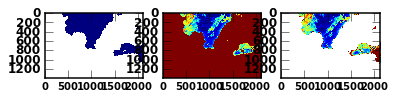

In [24]:
plt.figure()
plt.subplot(131)
plt.imshow(mask_arr_swath)
plt.subplot(132)
plt.imshow(wind_speed_asar, vmin=0, vmax=5)
plt.subplot(133)
plt.imshow(ma.masked_where(mask_arr_swath.mask, wind_speed_asar), vmin=0, vmax=5)

In [25]:
# Add mask to initial NCEP data
area_def_ncep = pr.geometry.SwathDefinition(lons=ncepGFSmodelWind['lons_wind'], lats=ncepGFSmodelWind['lats_wind'])
mask_arr_ncep, scaling, intercept = pr.kd_tree.resample_nearest(area_def_4326, mask_arr_4326, area_def_ncep, \
                                             radius_of_influence=4*pxlResWind.max(), epsilon=0.5, fill_value=None)
# mask_arr_ncep = apply_read_scaling(mask_arr_ncep, scaling, intercept)
ncepGFSmodelWind['wind_speed'] = ma.masked_where(mask_arr_ncep.mask, ncepGFSmodelWind['wind_speed'])

# Add mask to ASAR wind and reprojected NCEP
wind_speed_asar = ma.masked_where(mask_arr_swath.mask, wind_speed_asar)
ncepGFSmodelWindSwath['wind_speed'] = ma.masked_where(mask_arr_swath.mask, ncepGFSmodelWindSwath['wind_speed'])

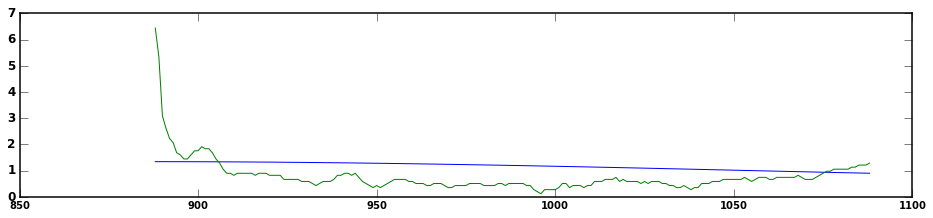

In [26]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.plot(ncepGFSmodelWindSwath['wind_speed'][600,:])
plt.plot(wind_speed_asar[600,:])

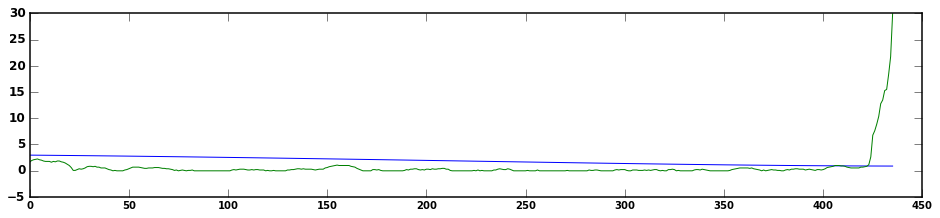

In [27]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.plot(ncepGFSmodelWindSwath['wind_speed'][:,800])
plt.plot(wind_speed_asar[:,800])

## NB! Don't forget to flipud when bearing.mean() >200
## NB! Don't forget to fliplr when bearing.mean() < 200

In [28]:
print 'bearing = %.2f' % bearing.mean()

if bearing.mean() < 200:
    orbit = 'Ascending'
    wind_speed_asar = fliplr(wind_speed_asar)
    lats_2 = fliplr(lats_2)
    lons_2 = fliplr(lons_2)
    mask_arr_swath = fliplr(mask_arr_swath)
    for k, v in ncepGFSmodelWindSwath.iteritems():
        ncepGFSmodelWindSwath[k] = fliplr(v)
    for k, v in roughnessNrmlzd.iteritems():
        roughnessNrmlzd[k] = fliplr(v)
    for k, v in sigma0w.iteritems():
        sigma0w[k] = fliplr(v)
elif bearing.mean() > 200:
    orbit = 'Descending'
    wind_speed_asar = flipud(wind_speed_asar)
    lats_2 = flipud(lats_2)
    lons_2 = flipud(lons_2)
    mask_arr_swath = flipud(mask_arr_swath)
    for k, v in ncepGFSmodelWindSwath.iteritems():
        ncepGFSmodelWindSwath[k] = flipud(v)
    for k, v in roughnessNrmlzd.iteritems():
        roughnessNrmlzd[k] = flipud(v)
    for k, v in sigma0w.iteritems():
        sigma0w[k] = flipud(v)
del k,v

bearing = 190.81


bearing = 190.81


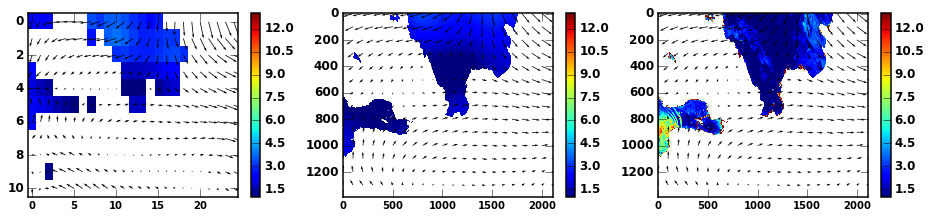

In [29]:
min_speed = 1
max_speed = 13

print 'bearing = %.2f' % bearing.mean()

plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(131)
plt.imshow(ncepGFSmodelWind['wind_speed'], vmin=min_speed, vmax=max_speed, interpolation="nearest")
plt.jet()
plt.colorbar()
plt.axis('tight')
plt.quiver(ncepGFSmodelWind['u'], ncepGFSmodelWind['v'])

X,Y = meshgrid( arange(0,roughness[p].shape[1]),arange(0,roughness[p].shape[0]) )
U = (ncepGFSmodelWindSwath['u'])
V = (ncepGFSmodelWindSwath['v'])
scl = 100

plt.subplot(132)
plt.imshow((ncepGFSmodelWindSwath['wind_speed']), vmin=min_speed, vmax=max_speed)
plt.jet()
plt.colorbar()
plt.axis('tight')
plt.quiver(X[::scl,::scl], Y[::scl,::scl], U[::scl,::scl], V[::scl,::scl])


plt.subplot(133)
plt.imshow((wind_speed_asar), vmin=min_speed, vmax=max_speed)
plt.jet()
plt.colorbar()
plt.axis('tight')
plt.quiver(X[::scl,::scl], Y[::scl,::scl], U[::scl,::scl], V[::scl,::scl])

In [30]:
print startTime, latlim, lonlim
print 'http://earth.nullschool.net/#'+startTime.strftime("%Y/%m/%d/")+'%.2d' %(ncepGFSmodelWind['baseHour'])+'00Z/wind/surface/level/orthographic=-327.02,60.84,3000'

2015-06-22 04:16:59.130419 (59.046967619209084, 60.952487996484194) (28.668874547994367, 33.704392334077433)
http://earth.nullschool.net/#2015/06/22/0000Z/wind/surface/level/orthographic=-327.02,60.84,3000


## NonInteractive Plot

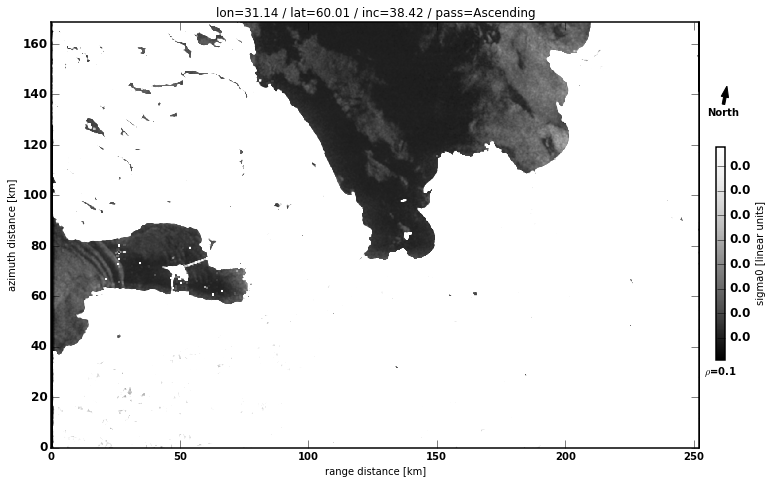

In [31]:
from scipy.stats import scoreatpercentile
from numpy import array, sin

import matplotlib.pyplot as plt
import matplotlib.cm as cm

vmin = None
vmax = None
cmap='Greys_r'
p = polarization[0]

# data = ma.masked_where(mask_arr_swath.mask, sigma0w[p])
data = sigma0w[p][::scale,::scale]

# Calculate vmin and vmax from sea surface only
if vmin is None:
    vmin = scoreatpercentile(data[~mask_arr_swath.mask[::scale,::scale]], 0.1)
if vmax is None:
    vmax = scoreatpercentile(data[~mask_arr_swath.mask[::scale,::scale]], 97.)

dShape = array(data.shape).astype('float')
dist = (array(dShape)-1)*pxlResSARm/1e3

# Make figure
figSize = (9, 9*dShape[0]/dShape[1])
dpi = dShape[1]/figSize[0]
margin = array(((figSize[0]*dpi-dShape[0])/4, 60))
imsizeN = dShape[::-1].astype('float')/figSize/dpi
marginN = margin.astype('float')/figSize/dpi

plt.close('all')

fig = plt.figure(figsize=figSize, dpi=dpi)
plt.subplots_adjust(bottom=0.05, top=0.95, left=0.05, right=0.95,
                    wspace=0.15, hspace=0.15)
imax = fig.add_axes([marginN[0], marginN[1], imsizeN[0], imsizeN[1]])
imax.set_xlim(0, dist[1])
imax.set_ylim(0, dist[0])
plt.imshow(data, interpolation='nearest', vmin=vmin,
            vmax=vmax,
            extent=[0, dist[1], 0, dist[0]], aspect='auto')
plt.set_cmap(cmap) 
imax.set_xlabel('range distance [km]')
imax.set_ylabel('azimuth distance [km]')
tit = 'lon=%.2f / lat=%.2f / inc=%.2f / pass=%s' % (lons_2.mean(), lats_2.mean(), incidenceAngle_2[p].mean(), orbit)
imax.set_title(tit)

# Add colorbar
cbax = fig.add_axes([1+1.3*marginN[0], .25, 20./figSize[1]/dpi, .50])
plt.colorbar(label='sigma0 [linear units]', cax=cbax, format='%.1f')
meanstr = r'$\rho$=%.1f' % data.mean()
cbax.text(0.5, -0.025, meanstr, ha='center', va='top')

# Add north
cpsizeN = (margin[0]-margin[1])/figSize/dpi
cpax = fig.add_axes([1+1.1*marginN[0], 0.85-cpsizeN[1]/2, cpsizeN[0], cpsizeN[1]])
plt.arrow(.5, .5, .5*cos((270-bearing.mean())*pi/180),
          .5*sin((270-bearing.mean())*pi/180), facecolor='black',
          width=0.07, length_includes_head=True,
          head_width=0.2, head_length=0.3)
plt.annotate('North', (.5, .4), ha='center', va='top')
cpax.set_axis_off()

# print vmin, vmax
# print figSize, imsizeN, dShape, marginN, margin, dpi


## Interactive plotting

In [32]:
# %matplotlib inline

def ntrctv_imshow(p = 'hh', vmi=-1., vma=1., cmap='Greys_r', crop='[:,:]', scale=1):
    # check if data type is dictionary and there is no wind
    if type(data) == dict and all(k!='wind_speed' for k in data.iterkeys()):
        plt.figure(figsize=(16,16*double(data[p][::scale,::scale].shape[0])/double(data[p][::scale,::scale].shape[1])))
        plt.imshow(eval("data[p][::scale,::scale]"+str(crop)), vmin=vmi, vmax=vma)
    elif type(data) == dict and any(k=='wind_speed' for k in data.iterkeys()):
        plt.figure(figsize=(16,16*double(data[p][::scale,::scale].shape[0])/double(data[p][::scale,::scale].shape[1])))
        X,Y = meshgrid( arange(0,eval("data[p][::scale,::scale]"+str(crop)).shape[1]),arange(0,eval("data[p][::scale,::scale]"+str(crop)).shape[0]) )
        U = (data['u'][::scale,::scale])
        V = (data['v'][::scale,::scale])
        U = eval("U"+str(crop))
        V = eval("V"+str(crop))
        scl = 100
        plt.quiver(X[::scl,::scl], Y[::scl,::scl], U[::scl,::scl], V[::scl,::scl])
        plt.imshow(eval("data[p][::scale,::scale]"+str(crop)), vmin=vmi, vmax=vma)
        plt.axis('tight')
    elif type(data) != dict:
        plt.figure(figsize=(16,16*double(data[::scale,::scale].shape[0])/double(data[::scale,::scale].shape[1])))
        plt.imshow(eval("data[::scale,::scale]"+str(crop)), vmin=vmi, vmax=vma)
    plt.colorbar()
    plt.set_cmap(cmap)    


In [ ]:
data=10*log10(sigma0w[p])
ntrctv = widgets.interact(ntrctv_imshow, \
                 vmi=widgets.FloatSliderWidget(min=-35, max=5, value=-20, step=0.5), \
                 vma=widgets.FloatSliderWidget(min=-35, max=5, value=-5., step=0.5), \
                 cmap = ['Greys_r', 'bone', 'RdBu_r'], crop = '[:,:]', \
                 scale=widgets.FloatSliderWidget(min=1, max=20, value=1, step=2));
# crop = '[1000:2500,1500:-1]'
# crop = '[600:1400,0:900]' - finnGulf
# crop = '[500:800,600:1000]' - Prirazlomnoe

In [ ]:
data=roughnessNrmlzd
# data[p] = np.where(data[p]<-1,-1,data[p])
# data[p] = np.where(data[p]>1,1,data[p])

ntrctv = widgets.interact(ntrctv_imshow, p = widgets.RadioButtons(description='polarization', options=data.keys()), \
                 vmi=widgets.FloatSliderWidget(min=-2, max=4, value=-2, step=0.5), \
                 vma=widgets.FloatSliderWidget(min=-2, max=4, value=4., step=0.5), \
                 cmap = ['bone', 'RdBu_r', 'Greys_r'], crop = '[:,:]', \
                 scale=widgets.FloatSliderWidget(min=1, max=20, value=10, step=2));
# crop = '[600:1400,0:900]'

In [ ]:
data = ncepGFSmodelWindSwath.copy()
wind = wind_speed_asar.copy()

ntrctv = widgets.interact(ntrctv_imshow, p = widgets.RadioButtons(description='wind speed', options=data.keys()), \
                 vmi=widgets.FloatSliderWidget(min=0, max=30, value=0, step=1), \
                 vma=widgets.FloatSliderWidget(min=0, max=30, value=5., step=1), \
                 cmap = ['jet'], crop = '[:,:]', \
                 scale=widgets.FloatSliderWidget(min=1, max=20, value=10, step=2));
# crop = '[600:1400,0:900]'

In [ ]:
from mpl_toolkits.basemap import Basemap
from matplotlib import cm

In [ ]:
# epsg 4326
data=roughnessNrmlzd.copy()

plt.close('all')
plt.figure(figsize=(16,16*double(data[p].shape[0])/double(data[p].shape[1])))

# width=7000000.
# height=7000000.
# m = Basemap(width=width,height=height,resolution='l',\
#             projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)

# Lat/Lon coords of image corners
ll_lat = lats_2.min()
# ur_lat = lats_2.max()-4
# ll_lon = lons_2.min()-15
# ur_lon = lons_2.max()+10
ur_lat = lats_2.max()
ll_lon = lons_2.min()
ur_lon = lons_2.max()
cent_lat = lats_2.mean()
cent_lon = lons_2.mean()
m = Basemap(epsg=4326, llcrnrlat=ll_lat, urcrnrlat=ur_lat,\
            llcrnrlon=ll_lon, urcrnrlon=ur_lon, \
            resolution='i')

m.bluemarble()

x,y=m(lons_2[::scale,::scale],lats_2[::scale,::scale])
CS=m.pcolormesh(x,y,roughnessNrmlzd[polarization[0]],cmap=cm.bone, vmin=-1.5, vmax=3)#,ps,cmap=cm.jet,extend='max')

m.drawmeridians(arange(round(lonlim[0]),round(lonlim[1]),1),labels=[0,0,0,1],color='y')
m.drawparallels(arange(round(latlim[0]),round(latlim[1]),1),labels=[1,0,0,0],color='y')
m.drawcoastlines(linewidth=0.5,color='0.5')
plt.title('Test')


In [ ]:
from numpy import array_split
splitted = array_split(roughnessNrmlzd[polarization[0]], 2)
print splitted[0].shape, splitted[1].shape

In [ ]:
print area_def_4326

In [ ]:
%%timeit -r 1 -n 1
import memory_profiler
area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
                          lonlim=lonlimGSHHS, latlim=latlimGSHHS, ellps="WGS84", res=.5*pxlResSARm)
mem = memory_profiler.memory_usage((pr.kd_tree.resample_nearest,(swath_def,roughnessNrmlzd[polarization[0]].ravel(),area_def_4326,4*pxlResSARm.max(),0.5,None,True,16,5)))
plt.close('all')
plt.plot(mem)

In [ ]:
from volumeutils import array_to_file, array_from_file, calculate_scale, apply_read_scaling, apply_write_scaling

In [ ]:
import numpy as np
scaling, intercept, _, _ = calculate_scale(roughnessNrmlzd[polarization[0]], np.int8, True)
print scaling, intercept

In [ ]:
roughness_4326, scaling, intercept = pr.kd_tree.resample_nearest(swath_def, roughnessNrmlzd[polarization[0]].ravel(), area_def_4326, \
                                             radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, \
                                             fill_value=None, segments=5, nprocs=8)

In [ ]:
import memory_profiler
area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
                          lonlim=lonlimGSHHS, latlim=latlimGSHHS, ellps="WGS84", res=.5*pxlResSARm)
mem = memory_profiler.memory_usage((pr.kd_tree.resample_nearest,(swath_def,roughnessNrmlzd[polarization[0]].ravel(),area_def_4326,4*pxlResSARm.max(),0.5,None,True,16,5)))
plt.close('all')
plt.plot(mem)

In [ ]:
from numpy import ones, int8, float64, inf
result = 3.333*ones((1e3,1e3), dtype=float64)
print result.nbytes/1024/1024
result = result.astype('uint16')
print result.nbytes/1024/1024
print result

In [ ]:
# get size of workspace variables
print raw_counts['vv'].nbytes/1024/1024

print [var for var in dir() if not (var.startswith('_') or var=='var')] 

%whos ndarray

try:
    del U, V, X, Y, bearing, bearing_2, lats_2, lts, lts_2, lons_2, lns, lns_2, mask_arr_4326, wind_dir_model_swath_rel, x, y
except:
    print 'Already deleted'

%whos ndarray

import gc
gc.collect()


In [ ]:
%%timeit -r 1 -n 1
# Reprojecting data
swath_def = pr.geometry.SwathDefinition(lons=lons_2[::scale,::scale], lats=lats_2[::scale,::scale])
area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
                          lonlim=lonlimGSHHS, latlim=latlimGSHHS, ellps="WGS84", res=.5*pxlResSARm)
roughness_4326 = pr.kd_tree.resample_nearest(swath_def, roughnessNrmlzd[polarization[0]].ravel(), area_def_4326, \
                                             radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, \
                                             fill_value=None, segments=5, nprocs=8)

In [ ]:
area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
                          lonlim=lonlimGSHHS, latlim=latlimGSHHS, ellps="WGS84", res=0.2*pxlResSARm)
print area_def_4326.size/3000000

In [ ]:
import pprofile
profiler = pprofile.Profile()

# Reprojecting data
swath_def = pr.geometry.SwathDefinition(lons=lons_2[::scale,::scale], lats=lats_2[::scale,::scale])
area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
                          lonlim=lonlimGSHHS, latlim=latlimGSHHS, ellps="WGS84", res=1*pxlResSARm)

with profiler:
    roughness_4326 = pr.kd_tree.resample_nearest(swath_def, roughnessNrmlzd[polarization[0]].ravel(), area_def_4326, \
                                                 radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, fill_value=None, segments=10, nprocs=8)

In [ ]:
profiler.print_stats()

In [ ]:
%load_ext memory_profiler

In [ ]:
%mprun -T mprun.txt -c -f pr.kd_tree.resample_nearest pr.kd_tree.resample_nearest(swath_def, roughnessNrmlzd[polarization[0]].ravel(), area_def_4326, \
                                                                               radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, fill_value=None, segments=10, nprocs=8)

In [ ]:
import memory_profiler

In [ ]:
# Reprojecting data
swath_def = pr.geometry.SwathDefinition(lons=lons_2[::scale,::scale], lats=lats_2[::scale,::scale])
area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
                          lonlim=lonlimGSHHS, latlim=latlimGSHHS, ellps="WGS84", res=1*pxlResSARm)

mem = memory_profiler.memory_usage((pr.kd_tree.resample_nearest,(swath_def,roughnessNrmlzd[polarization[0]].ravel(),area_def_4326,4*pxlResSARm.max(),0.5,None,True,10,10)))

In [ ]:
plt.close('all')
plt.plot(mem)

In [ ]:
%%timeit -r 1 -n 1
# Reprojecting data
swath_def = pr.geometry.SwathDefinition(lons=lons_2[::scale,::scale], lats=lats_2[::scale,::scale])
area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
                          lonlim=lonlimGSHHS, latlim=latlimGSHHS, ellps="WGS84", res=.2*pxlResSARm)
roughness_4326 = pr.kd_tree.resample_nearest(swath_def, roughnessNrmlzd[polarization[0]].ravel(), area_def_4326, \
                                             radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, fill_value=None, segments=100, nprocs=8)

In [ ]:
%%timeit -r 1 -n 1
# Reprojecting data
swath_def = pr.geometry.SwathDefinition(lons=lons_2[::scale,::scale], lats=lats_2[::scale,::scale])
area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
                          lonlim=lonlimGSHHS, latlim=latlimGSHHS, ellps="WGS84", res=.2*pxlResSARm)
roughness_4326 = pr.kd_tree.resample_nearest(swath_def, roughnessNrmlzd[polarization[0]].ravel(), area_def_4326, \
                                             radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, fill_value=None, nprocs=8)

In [ ]:
data=roughness_4326.copy()
# data[p] = np.where(data[p]<-1,-1,data[p])
# data[p] = np.where(data[p]>1,1,data[p])

ntrctv = widgets.interact(ntrctv_imshow, \
                 vmi=widgets.FloatSliderWidget(min=-2, max=4, value=-1.5, step=0.5), \
                 vma=widgets.FloatSliderWidget(min=-2, max=4, value=3., step=0.5));